In [3]:
!cv2 version

/bin/bash: cv2: command not found


In [80]:
!pip install split-folders tqdm

In [344]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Generate batches of tensor image data with real-time data augmentation.
from tensorflow.keras.applications import MobileNetV2 # CNN architecture that works well w/mobile devices as well
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Preprocesses a tensor or Numpy array encoding a batch of images.
from tensorflow.keras.preprocessing.image import img_to_array, load_img 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical # converts a class vector (integers) to a binary class matrix
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import cv2
import numpy as np
import pandas as pd
import os
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgrey'

## Preprocessing the data

In [345]:
# init the initial learning rate, number of epochs to train for, and batch size
init_lr = 1e-4
epochs = 40
bs = 32
image_size = (224,224)

In [346]:
DIRECTORY = r"data"
CATEGORIES = ["with_mask","without_mask","mask_weared_incorrect"]

In [347]:
print("[INFO] loading images...")

[INFO] loading images...


In [291]:
# splitfolders.ratio('data',output='split_data', seed=1337, ratio=(.8,.1,.1))

## image_dataset_from_directory Pipeline

In [292]:
# create batch datasets

train_ds = image_dataset_from_directory('data',
                                       validation_split=0.2,
                                       subset='training',
                                       seed=1337,
                                       image_size=image_size,
                                       batch_size=bs)
test_ds = image_dataset_from_directory('data',
                                      validation_split=0.2,
                                      subset='validation',
                                      seed=1337,
                                      image_size=image_size,
                                      batch_size=bs)

Found 8982 files belonging to 3 classes.
Using 7186 files for training.
Found 8982 files belonging to 3 classes.
Using 1796 files for validation.


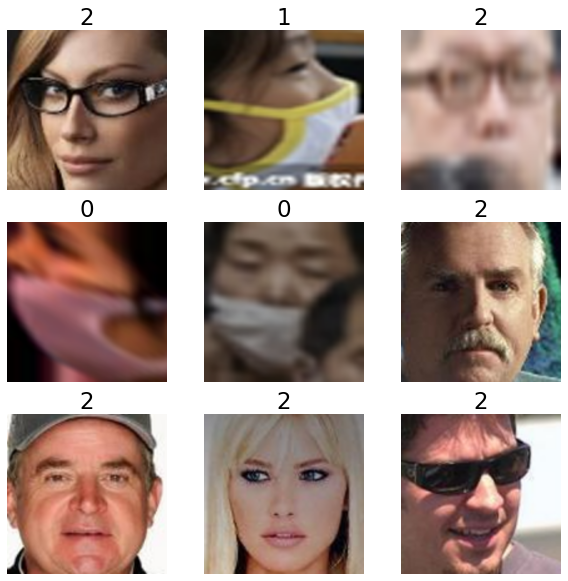

In [348]:
# visualize the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## keras_generator Pipeline

In [124]:
# for image_dataset_from_directory

# data_augmentation = keras.Sequential(
#     [
#         preprocessing.RandomFlip("horizontal"),
#         preprocessing.RandomRotation(0.1),
#         preprocessing.RandomHeight(0.2),
#         preprocessing.RandomWidth(0.2),
    
#     ]
# )

In [105]:
# train_ds = train_ds.prefetch(buffer_size=32)
# test_ds = test_ds.prefetch(buffer_size=32)

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

## Model building w/o function (hidden just in case)

In [139]:
# # load MobileNetV2 network, ensuring the head FC (Fully Connected) laery sets are left off
# inputs = Input(shape=(192,192,3))
# baseModel = MobileNetV2(input_shape=(192,192,3),weights="imagenet", include_top=False, input_tensor=inputs)

In [140]:
# # create the head of the model that will be placed on top of the base model
# headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(6,6))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(128, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(64, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(3, activation="softmax")(headModel)

In [141]:
# # place the head FC model on top of the base model (this will become the actual model we will train)
# model = Model(inputs=baseModel.input, outputs=headModel)

# # lopp over all layers in the base model and freeze them so they will not be updated during the first training process
# for layer in baseModel.layers:
#     layer.trainable=False

In [142]:
# # compile model
# print("[INFO] compiling model...")
# opt = Adam(lr=init_lr,decay=init_lr / epochs)
# model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [143]:
# # train head of the network
# print("[INFO] training head...")
# H = model.fit(
#         train,
#         steps_per_epoch=len(x_train[0]) // bs,
#         validation_data=val,
#         validation_steps=len(x_val[0]) //bs,
#         epochs=epochs,
#         callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                   verbose=1,
#                                                   patience=4,
#                                                   restore_best_weights=True)
# )

## Model Building w/function

In [349]:
def build_model(num_classes, img_size=224):
    # load MobileNetV2 network, ensuring the head FC (Fully Connected) layer sets are left off
    inputs = Input(shape=(img_size,img_size,3))    
    baseModel = MobileNetV2(input_shape=(img_size,img_size,3),weights="imagenet", include_top=False, input_tensor=inputs)
    
    
    # create the head of the model that will be placed on top of the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    
    headModel = Dense(num_classes, activation="softmax")(headModel)
    
    # place the head FC model on top of the base model (this will become the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

    # lopp over all layers in the base model and freeze them so they will not be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable=False
        
    # compile model
    print("[INFO] compiling model...")
    opt = Adam(lr=init_lr,decay=init_lr / epochs)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [350]:
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2)
    

In [356]:
train = datagen.flow_from_directory('split_data/train', class_mode='categorical',target_size=image_size, batch_size=bs)
test = datagen.flow_from_directory('split_data/test',class_mode='categorical',target_size=image_size, batch_size=bs)
# val = datagen.flow_from_directory('split_data/val', class_mode='categorical',target_size=image_size,batch_size=bs)

x_train, y_train = next(train)
x_test,y_test = next(test)
# x_val, y_val = next(val)


Found 7185 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [358]:
num_classes = len(CATEGORIES)
model = build_model(num_classes)

# train head of the network
print("[INFO] training head...")
H = model.fit(
        train,
        steps_per_epoch=(len(train) // bs),
        validation_data=(x_test,y_test),
        validation_steps=len(x_test) // bs,
        batch_size=bs,
        epochs=epochs,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  verbose=1,
                                                  patience=4,
                                                  restore_best_weights=True)
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/40
7/7 [==============================] - 8s 918ms/step - loss: 1.8958 - accuracy: 0.3310 - val_loss: 1.3322 - val_accuracy: 0.3438
Epoch 2/40
7/7 [==============================] - 5s 721ms/step - loss: 1.6770 - accuracy: 0.3384 - val_loss: 0.9684 - val_accuracy: 0.4375
Epoch 3/40
7/7 [==============================] - 5s 719ms/step - loss: 1.3832 - accuracy: 0.3910 - val_loss: 0.8895 - val_accuracy: 0.6562
Epoch 4/40
7/7 [==============================] - 5s 720ms/step - loss: 1.4041 - accuracy: 0.3218 - val_loss: 0.8441 - val_accuracy: 0.6250
Epoch 5/40
7/7 [==============================] - 5s 721ms/step - loss: 1.1011 - accuracy: 0.4957 - val_loss: 0.8324 - val_accuracy: 0.6875
Epoch 6/40
7/7 [==============================] - 5s 720ms/step - loss: 1.1182 - accuracy: 0.4568 - val_loss: 0.7625 - val_accuracy: 0.6250
Epoch 7/40
7/7 [==============================] - 5s 725ms/step - loss: 0.9525 - accuracy: 0.5599 - val_loss: 

In [340]:
x_test.shape

(32, 224, 224, 3)

In [365]:
ev = model.evaluate(x_test, batch_size=bs)

1/1 [==============================] - 0s 456ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


1st try: loss 0.6 accuracy .75 <br>
2nd try: loss 0.59 accuracy .77 <br>
3rd try: loss 0.57 accuracy .77

In [360]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=bs)

[INFO] evaluating network...


In [361]:
# for each img in the testing set, we need to find idx of label w/corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# ! DO CLASSIFICATION REPORT

In [367]:
print(classification_report(np.argmax(y_test, axis=1), predIdxs, target_names=['Mask','No Mask','Mask Worn Incorrectly']))

                       precision    recall  f1-score   support

                 Mask       0.83      0.77      0.80        13
              No Mask       0.86      0.86      0.86        14
Mask Worn Incorrectly       0.83      1.00      0.91         5

             accuracy                           0.84        32
            macro avg       0.84      0.88      0.86        32
         weighted avg       0.84      0.84      0.84        32



In [368]:
# serialize the model to disk
print('[INFO] saving mask detector model...')
model.save("mask_detector.model", save_format='h5')

[INFO] saving mask detector model...


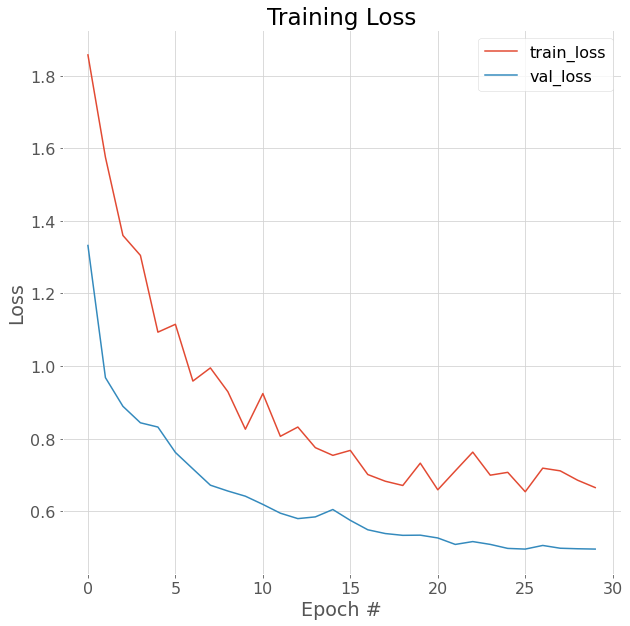

In [363]:
# plot the training loss and accuracy

plt.figure(figsize=(10,10))
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')

plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc='upper right')

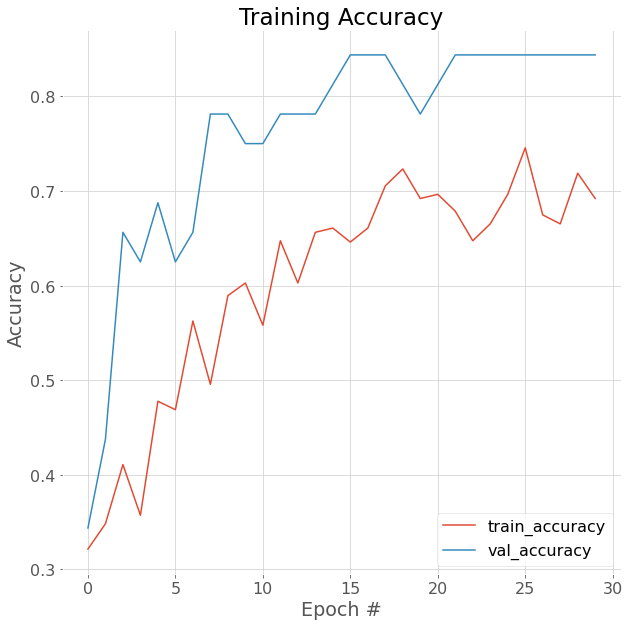

In [364]:
plt.figure(figsize=(10,10))
plt.plot(H.history['accuracy'], label='train_accuracy')
plt.plot(H.history['val_accuracy'], label='val_accuracy')

plt.title('Training Accuracy')
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')